In [1]:

import os
import tensorflow as tf
import pandas as pd
import keras
import numpy as np
#from keras.layers import Embedding
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import math
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


In [151]:
samsung=pd.read_excel('samsung.xlsx',header = 0)  # 파일 읽기(yahoo데이터)
samsung.columns=['date','open','low','high','close','volume','adj.close'] #열 이름
ss_close=samsung['close']  #종가만 뽑기
type(ss_close)
ss_nparr=ss_close.values[::1] #종가를 np array로

In [4]:
samsung

,date,open,low,high,close,volume,adj.close
0,2000-01-05,6060,5520,5800,5580,74680000,0.082740
1,2000-01-06,5780,5580,5750,5620,54390000,0.083333
2,2000-01-07,5670,5360,5560,5540,40305000,0.082147
3,2000-01-10,5770,5580,5600,5770,46880000,0.085558
4,2000-01-11,6100,5770,5820,5770,59745000,0.085558
...,...,...,...,...,...,...,...
5016,2019-12-24,55700,54800,55600,55000,11868463,55000.000000
5017,2019-12-26,55400,54400,54700,55400,9645034,55400.000000
5018,2019-12-27,56900,55500,55700,56500,12313056,56500.000000
5019,2019-12-30,56600,55700,56200,55800,8356767,55800.000000


In [189]:
adjclose=samsung['adj.close']
close=samsung['close']

In [194]:
expected_return_adjclose=[]
expected_return_close=[]
for i in range(len(range(5020))):
    expected_return_adjclose.append((adjclose[i+1]-adjclose[i])/adjclose[i])
    expected_return_close.append( (close[i+1]-close[i])/close[i])

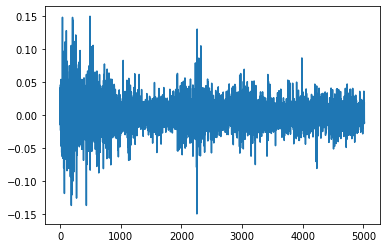

In [196]:
plt.plot(expected_return_close)

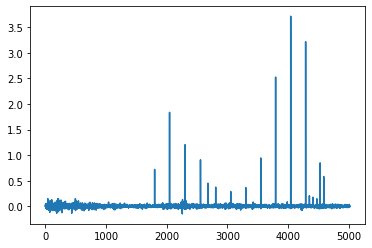

In [195]:
plt.plot(expected_return_adjclose)

In [182]:
samsung['adj.close'][samsung['date']=='2018-04-17']

4604    48785.972656
Name: adj.close, dtype: float64

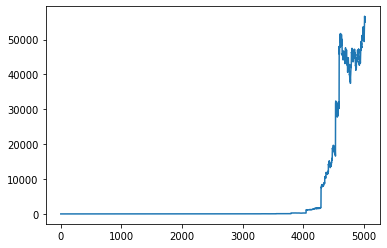

In [143]:
plt.plot(samsung['adj.close'])

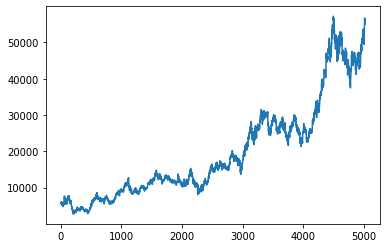

In [144]:
plt.plot(samsung['close'])

In [5]:
ss_nparr=ss_nparr.astype('float32')

In [6]:
look_back=1
def create_dataset(dataset,look_back=1):
    dataX, dataY=[], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i + look_back)]
        dataX.append(a)
        dataY.append(dataset[i+look_back])
    return np.array(dataX),np.array(dataY)    #데이터셋으로 바꾸기

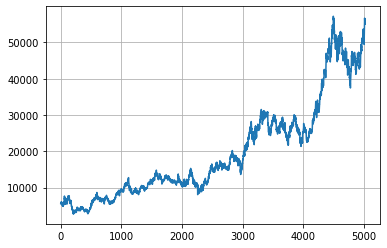

In [7]:
new_ssarr=ss_nparr.reshape(-1,1)
new_ssarr  # fit을 위한 reshape
plt.grid(True)
plt.plot(new_ssarr)

In [8]:
scaler=MinMaxScaler(feature_range=(0,1))
ss_trsf=scaler.fit_transform(new_ssarr)

In [9]:
train_size=int(len(ss_trsf)*0.9)
test_size=len(ss_trsf) - train_size   #train size, test size (90%사용)

In [11]:
train, test=ss_trsf[0:train_size], ss_trsf[train_size:len(ss_trsf),:]
#데이터의 train size, test size만큼 뽑아서 test,train만듬

In [124]:
trainX , trainY= create_dataset(train, look_back)
testX, testY= create_dataset(test, look_back)
print("#"*30)
print(testY)

##############################
[[0.88107914]
 [0.90420264]
 [0.9001652 ]
 [0.9060378 ]
 [0.8917233 ]
 [0.88695174]
 [0.87887686]
 [0.88952106]
 [0.89612776]
 [0.8517159 ]
 [0.8619931 ]
 [0.8344651 ]
 [0.85575336]
 [0.8851166 ]
 [0.8972289 ]
 [0.8873188 ]
 [0.90640485]
 [0.9045697 ]
 [0.8748394 ]
 [0.84621036]
 [0.8351991 ]
 [0.8344651 ]
 [0.84070474]
 [0.86749864]
 [0.8605249 ]
 [0.86566347]
 [0.8550193 ]
 [0.8351991 ]
 [0.85208297]
 [0.8553863 ]
 [0.87227017]
 [0.8818132 ]
 [0.8898881 ]
 [0.86382824]
 [0.86566347]
 [0.8641953 ]
 [0.8252891 ]
 [0.8293265 ]
 [0.8201505 ]
 [0.7904203 ]
 [0.7940907 ]
 [0.7702331 ]
 [0.7889521 ]
 [0.82235277]
 [0.84914666]
 [0.83776844]
 [0.81978345]
 [0.81758124]
 [0.8080382 ]
 [0.8164801 ]
 [0.8194164 ]
 [0.8194164 ]
 [0.8135438 ]
 [0.79445773]
 [0.7794091 ]
 [0.8128097 ]
 [0.8421729 ]
 [0.85281706]
 [0.8627271 ]
 [0.8627271 ]
 [0.8979629 ]
 [0.89979815]
 [0.8957607 ]
 [0.8884199 ]
 [0.88107914]
 [0.88952106]
 [0.88695174]
 [0.9001652 ]
 [0.8623601 ]
 [0

In [13]:
trainX=np.reshape(trainX,(trainX.shape[0],1,trainX.shape[1]))
testX=np.reshape(testX,(testX.shape[0],1,testX.shape[1]))
#[sample,feature]에서 [samples,time steps,features]로 바꿈

In [104]:
# LSTM만들기
model=Sequential()
model.add(LSTM(2,input_shape=(1,look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')
model.fit(trainX,trainY,epochs=1000,batch_size=5, verbose=2)
#trainX:모의고사 문제 , trainY:모의고사 답
#epochs 모의고사 1회분을 몇번 풀까?
#batch_size 몇 문제씩 풀어보고 답을 맞춰볼까?
#verbose=2는 JupyterNotebook에서 학습 중 출력되는 문구를 막대바로 설정

Epoch 1/1000
 - 1s - loss: 0.0114
Epoch 2/1000
 - 1s - loss: 1.6871e-04
Epoch 3/1000
 - 1s - loss: 7.2817e-05
Epoch 4/1000
 - 1s - loss: 7.1883e-05
Epoch 5/1000
 - 1s - loss: 7.1371e-05
Epoch 6/1000
 - 1s - loss: 7.0642e-05
Epoch 7/1000
 - 1s - loss: 7.0393e-05
Epoch 8/1000
 - 1s - loss: 6.9160e-05
Epoch 9/1000
 - 1s - loss: 6.9180e-05
Epoch 10/1000
 - 1s - loss: 6.9155e-05
Epoch 11/1000
 - 1s - loss: 6.6803e-05
Epoch 12/1000
 - 1s - loss: 6.5188e-05
Epoch 13/1000
 - 1s - loss: 6.4173e-05
Epoch 14/1000
 - 1s - loss: 6.2701e-05
Epoch 15/1000
 - 1s - loss: 6.2170e-05
Epoch 16/1000
 - 1s - loss: 6.2842e-05
Epoch 17/1000
 - 1s - loss: 6.0757e-05
Epoch 18/1000
 - 1s - loss: 6.0278e-05
Epoch 19/1000
 - 1s - loss: 6.0340e-05
Epoch 20/1000
 - 1s - loss: 5.8929e-05
Epoch 21/1000
 - 1s - loss: 5.8473e-05
Epoch 22/1000
 - 1s - loss: 5.9723e-05
Epoch 23/1000
 - 1s - loss: 5.8563e-05
Epoch 24/1000
 - 1s - loss: 5.8452e-05
Epoch 25/1000
 - 1s - loss: 5.7129e-05
Epoch 26/1000
 - 1s - loss: 5.7207e-05

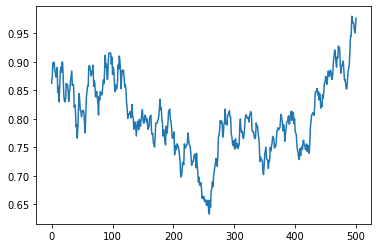

In [105]:
testPredict=model.predict(testX)
plt.plot(testPredict)

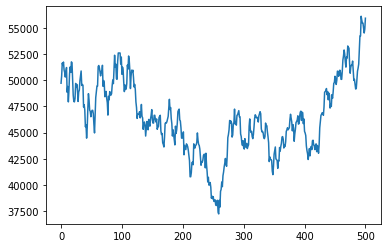

In [106]:
testPredict=scaler.inverse_transform(testPredict)
plt.plot(testPredict)

In [125]:
testY=scaler.inverse_transform(testY)
# scaler.inverse_transform은 한번만 하기, 여러번하면 값이 이상해짐 

In [126]:
testScore=math.sqrt(mean_squared_error(testY,testPredict))
print('train score: %.2f RMSE' % testScore)
print(testScore)

train score: 798.08 RMSE
798.0826633250468


In [127]:
lastX = new_ssarr[-1]
lastX = np.reshape(lastX, (1, 1, 1))
lastY = model.predict(lastX)
lastY = scaler.inverse_transform(lastY)
# 데이터 입력 마지막 다음날 종가 예측
print('마지막날 종가 예측: %d' % lastY)

마지막날 종가 예측: 116239


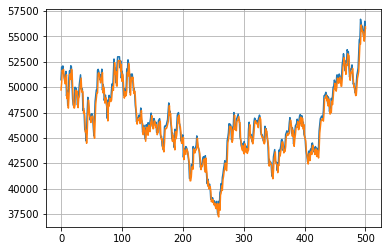

In [128]:
plt.grid(True)
plt.plot(testY) #파란선
plt.plot(testPredict)
plt.show()

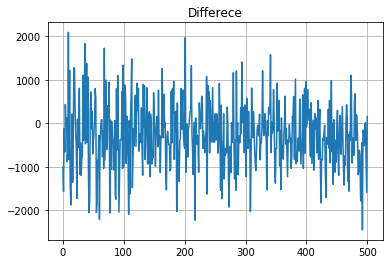

In [129]:
#예측의 차이값
plt.title("Differece")
plt.grid(True)
#plt.figure(figsize=(100,50))
plt.plot(testPredict-testY)

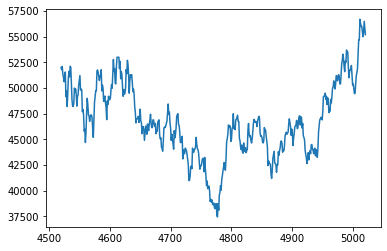

In [130]:
testrange=samsung[-501:]
plt.plot(testrange['close'])
testclose=np.array(samsung['close'][-501:])
testclose_rs=testclose.reshape(-1,1)

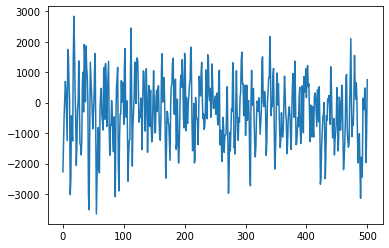

In [131]:
plt.plot(testPredict-testclose_rs)
testopen=np.array(samsung['open'][-501:])
testhigh=np.array(samsung['high'][-501:])
testlow=np.array(samsung['low'][-501:])

In [132]:
Predictarray=testPredict

In [133]:
# 수익이 난 날: 예측가격이 시가보다 낮을 경우 저가가 예측가격보다 낮으면 수익
# 예측가격이 시가보다 높을 경우 고가가 예측가격보다 높으면 수익
expected_profitday=[]
for day in range(len(testopen)):
    if testopen[day]<Predictarray[day] and testhigh[day]>Predictarray[day]:
        expected_profitday.append(day)
    elif testopen[day]>Predictarray[day] and testlow[day]<Predictarray[day]:
        expected_profitday.append(day)
    else:
        pass

In [134]:
print("501일 동안 예상 수익 확률은 {}% 입니다".format(len(expected_profitday)/len(Predictarray)*100))

501일 동안 예상 수익 확률은 36.12774451097805% 입니다


In [135]:
expected_profit=[]
for day in range(len(testopen)):
    if testopen[day]<Predictarray[day] and testhigh[day]>Predictarray[day]:
        expected_profit.append(Predictarray[day]-testopen[day])
    elif testopen[day]>Predictarray[day] and testlow[day]<Predictarray[day]:
        expected_profit.append(testopen[day]-Predictarray[day])
    else:
        pass

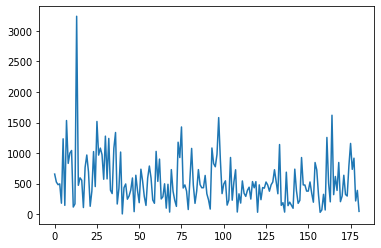

In [136]:
plt.plot(expected_profit)

In [137]:
print("501일 동안 예상 수익은 {} 원입니다".format(sum(expected_profit)))

501일 동안 예상 수익은 [97506.125] 원입니다


In [138]:
tradingday=[]
for i in range(0,501):
    tradingday.append(i)  # 전체 매매일 (test일수 501이라 가정)

In [139]:
expected_loss=[]
for day in range(len(tradingday)):
    if day not in expected_profitday:
        expected_loss.append(testopen[day]*(3/100))   #장가 기준 손절 3%라고 가정
    else:
        pass

In [140]:
print("501일 동안 예상 손실은 {} 원입니다".format(sum(expected_loss)))

501일 동안 예상 손실은 453694.5 원입니다


In [141]:
print("501일 동안 예상 순손익은 {} 원입니다".format(sum(expected_profit)-sum(expected_loss)))

501일 동안 예상 순손익은 [-356188.38] 원입니다
